In [1]:
!pip install langgraph langsmith langchain langchain-groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00


In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [5]:
!pip install arxiv wikipedia

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.7 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=50b86921ef3200b5dd95653b1eedb4704b04bfe173d98591d72688c0e335fdfb
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=a260af3afe6114bce526f88e83cd109cbfd3e2e6612dd43528821a4fcab557be
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built wikipedia sgmllib3k


In [8]:
# Working with Tools

from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and Wikipedia Tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper = api_wrapper)

# response we get once at a time and charactrs we get is 300

In [14]:
wiki_tool("Who is Shahrukh Khan SRK")

'Page: Shah Rukh Khan filmography\nSummary: Shah Rukh Khan is an Indian actor, producer and television personality who works in Hindi films. He began his acting career by playing a soldier in the Doordarshan series Fauji (1988), a role that garnered him recognition and led to starring roles in more te'

In [15]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [16]:
tools = [wiki_tool]

In [30]:
## Langgraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [31]:
from langgraph.graph import StateGraph,START,END

In [32]:
graphbuilder = StateGraph(State)


In [33]:
from langchain_groq import ChatGroq

In [34]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')
langsmith_api_key = userdata.get('LANGSMITH_API_KEY')

In [35]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name= "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d61195aa4d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d61195f0460>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [36]:
llm_with_tools = llm.bind_tools(tools = tools)

In [37]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [38]:
from langgraph.prebuilt import ToolNode,tools_condition

In [39]:
graphbuilder.add_node("chatbot",chatbot)
graphbuilder.add_edge(START,"chatbot")
tool_node = ToolNode(tools=tools)
graphbuilder.add_node("tools",tool_node)
graphbuilder.add_conditional_edges(
    "chatbot",
    tools_condition
    )
graphbuilder.add_edge("tools","chatbot")
graphbuilder.add_edge("chatbot",END)

In [40]:
graph = graphbuilder.compile()

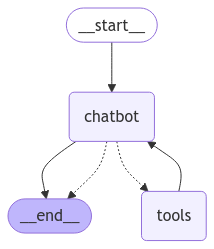

In [41]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [ ]:
while True:
  user_input = input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({"messages":("user",user_input)}):
    print(event.values())
    for value in event.values():
      # print(value['messages'])
      print("Assistant:", value["messages"][-1].pretty_print())

User: Hello
dict_values([{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a2nq', 'function': {'arguments': '{"query":"Hello"}', 'name': 'wikipedia'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 981, 'total_tokens': 1061, 'completion_time': 0.145454545, 'prompt_time': 0.053339354, 'queue_time': 0.0032401760000000043, 'total_time': 0.198793899}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82ecd690-609d-4641-8b6d-6860988a8c14-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Hello'}, 'id': 'call_a2nq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 981, 'output_tokens': 80, 'total_tokens': 1061})]}])
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_a2nq)
 Call ID: call_a2nq
  Args:
    query: Hello
Assistant: None
dict_values([{'messages': [To